In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Nlat = 100
Nlong = 200

lat_vect = np.linspace(-np.pi/2, np.pi/2, Nlat)
long_vect = np.linspace(-np.pi, np.pi, Nlong)

xy_ones = np.ones([Nlat, Nlong])
lat_arr = xy_ones * np.expand_dims(lat_vect, 1)
long_arr = xy_ones * np.expand_dims(long_vect, 0)

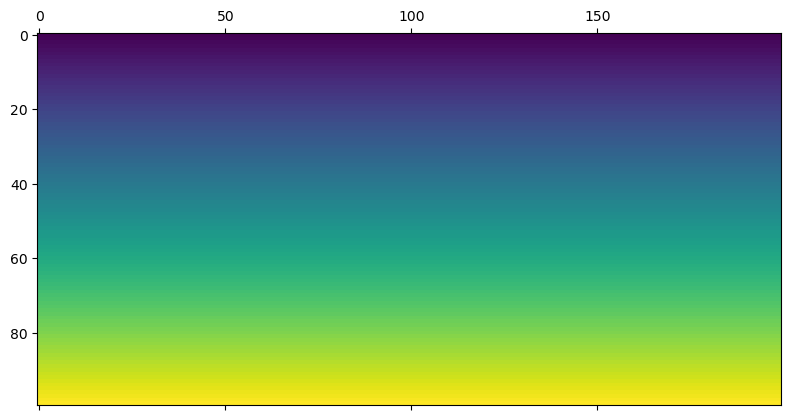

In [3]:
plt.matshow(lat_arr)

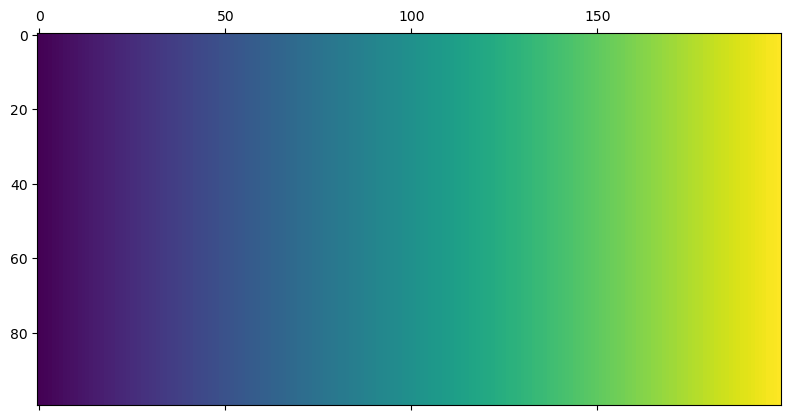

In [4]:
plt.matshow(long_arr)

In [5]:
def haversine(lon1, lat1, lon2, lat2):
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    return np.arcsin(np.sqrt(a))

In [6]:
def dist_map(lon, lat, long_arr, lat_arr):
    dist_arr = haversine(lon, lat, long_arr, lat_arr)
    return dist_arr

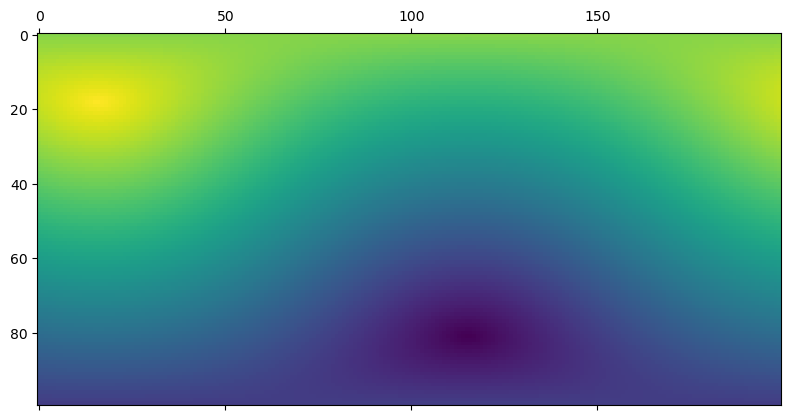

In [7]:
plt.matshow(dist_map(0.5, 1, long_arr, lat_arr))

In [8]:
from scipy.interpolate import RectBivariateSpline, RegularGridInterpolator

In [9]:
def ampliate(arr, N_hd = 1000):
    n_y, n_x = arr.shape
    lat_vec = np.linspace(-np.pi/2, np.pi/2, n_y)
    long_vec = np.linspace(-np.pi/2, np.pi/2, n_x)
    lat_vect_hd = np.linspace(-np.pi/2, np.pi/2, N_hd)
    long_vect_hd = np.linspace(-np.pi, np.pi, N_hd*2)
    xy_ones_hd = np.ones([N_hd, N_hd*2])
    lat_arr_hd = xy_ones_hd * np.expand_dims(lat_vect_hd, 1)
    long_arr_hd = xy_ones_hd * np.expand_dims(long_vect_hd, 0)
    
    _f = RectBivariateSpline(lat_vect, long_vect, arr, kx = 2, ky = 2)
    newarr = _f(lat_vect_hd, long_vect_hd)
    return newarr

In [10]:
N_plates = 10

centers = []
for i in range(N_plates):
    centers.append(tuple((np.random.rand(2)*2-1)*np.array([np.pi, np.pi/2])))

cent_dist = np.zeros([Nlat, Nlong, N_plates])
for i in range(N_plates):
    cent_dist[:,:,i] = dist_map(*centers[i], long_arr, lat_arr)
    #plt.matshow(cent_dist[:,:,i])

In [12]:
N_hd = 1000
cent_dist_hd = np.zeros([N_hd, 2*N_hd, N_plates])
for i in range(N_plates):
    cent_dist_hd[:,:,i] = ampliate(cent_dist[:,:,i], N_hd)

In [13]:
plate_map = np.argmin(cent_dist_hd, axis=2)

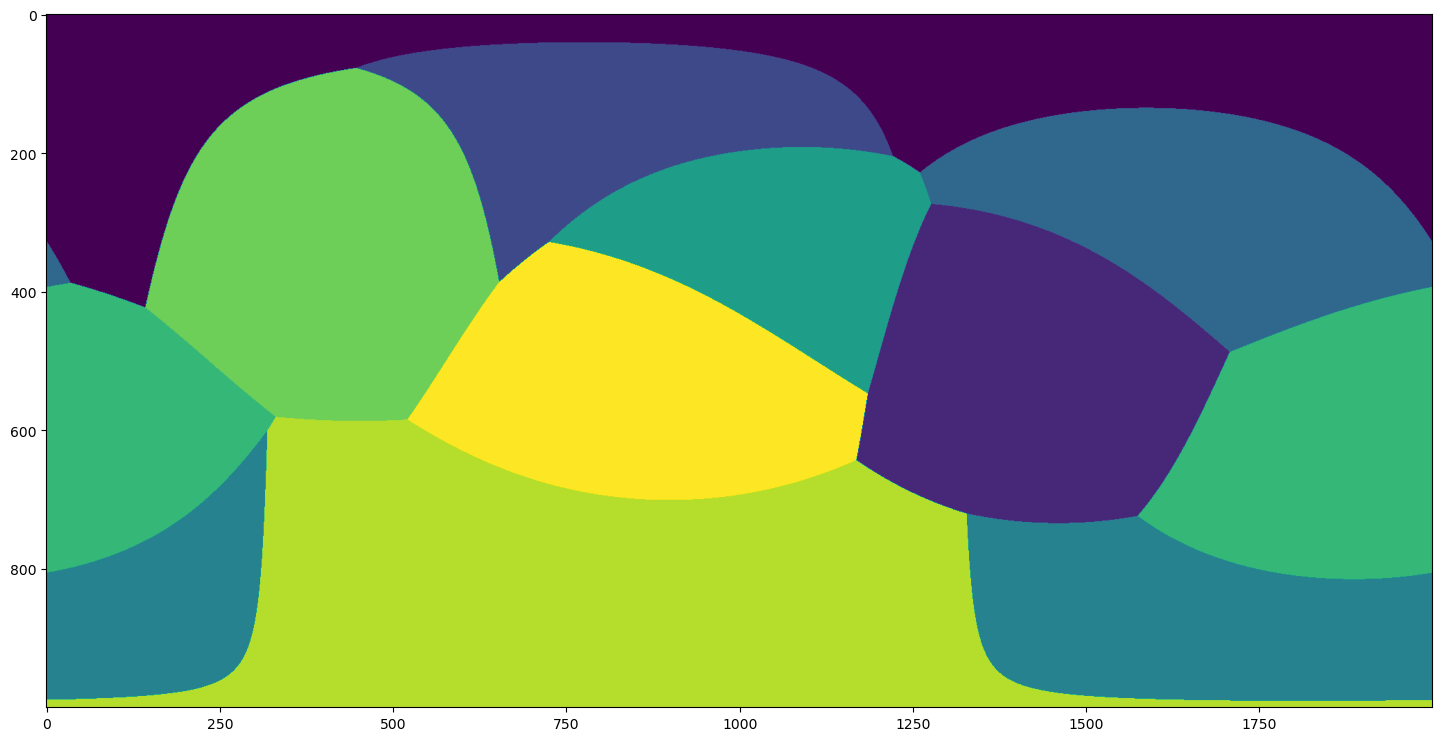

In [14]:
plt.figure(figsize=[18,9])
plt.imshow(plate_map)

In [15]:
import opensimplex

In [16]:
def noise_sphere(long_arr, lat_arr, N = 200, scale = 2):
    vector = np.linspace(-scale*np.pi, scale*np.pi, N)
    opensimplex.random_seed()
    noise_3d = opensimplex.noise3array(vector, vector,vector)
    interp = RegularGridInterpolator((vector, vector, vector), noise_3d)
    x_sph = np.cos(lat_arr)*np.cos(long_arr)*scale
    y_sph = np.cos(lat_arr)*np.sin(long_arr)*scale
    z_sph = np.sin(lat_arr)*scale
    noise_interp = interp((x_sph, y_sph, z_sph))
    return noise_interp

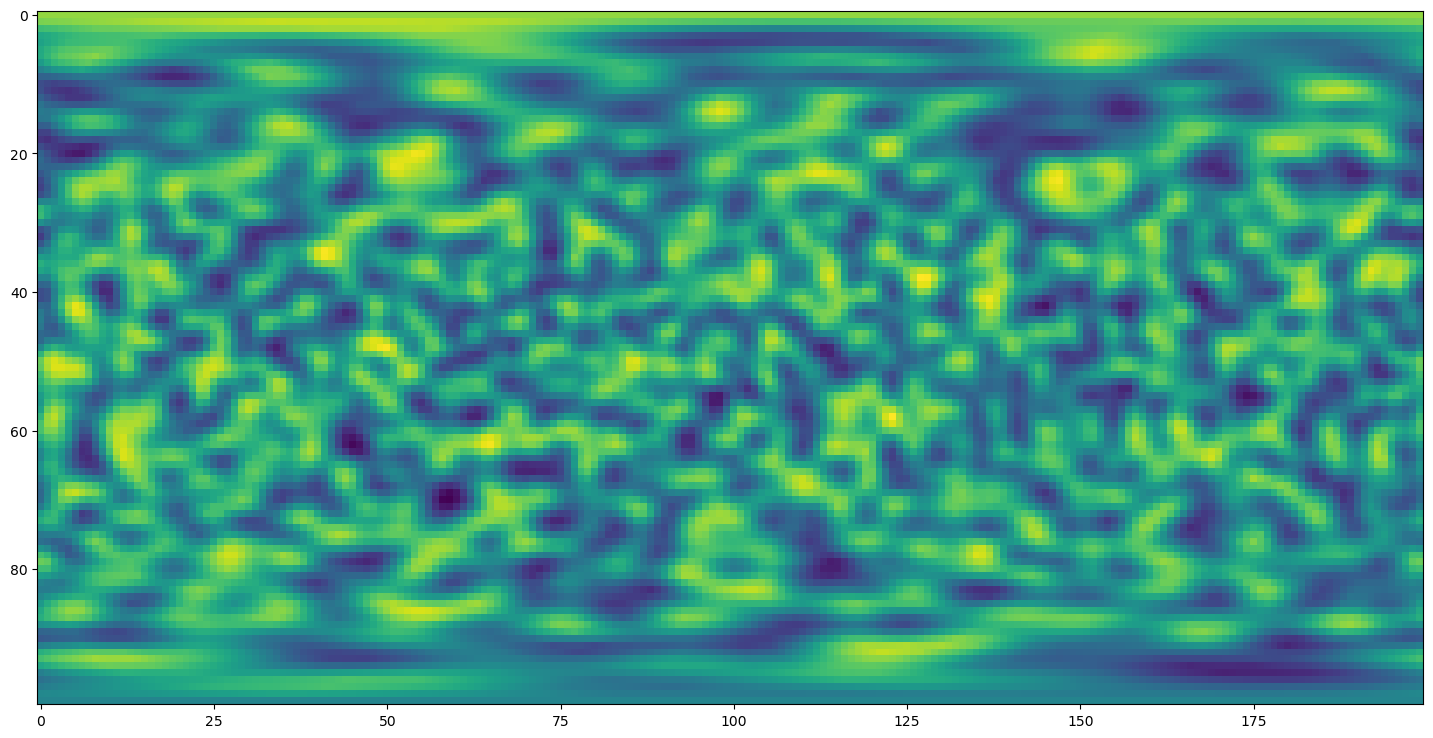

In [17]:
_noise_sph = noise_sphere(long_arr, lat_arr, N = 200, scale = 8)
plt.figure(figsize=[18,9])
plt.imshow(_noise_sph)

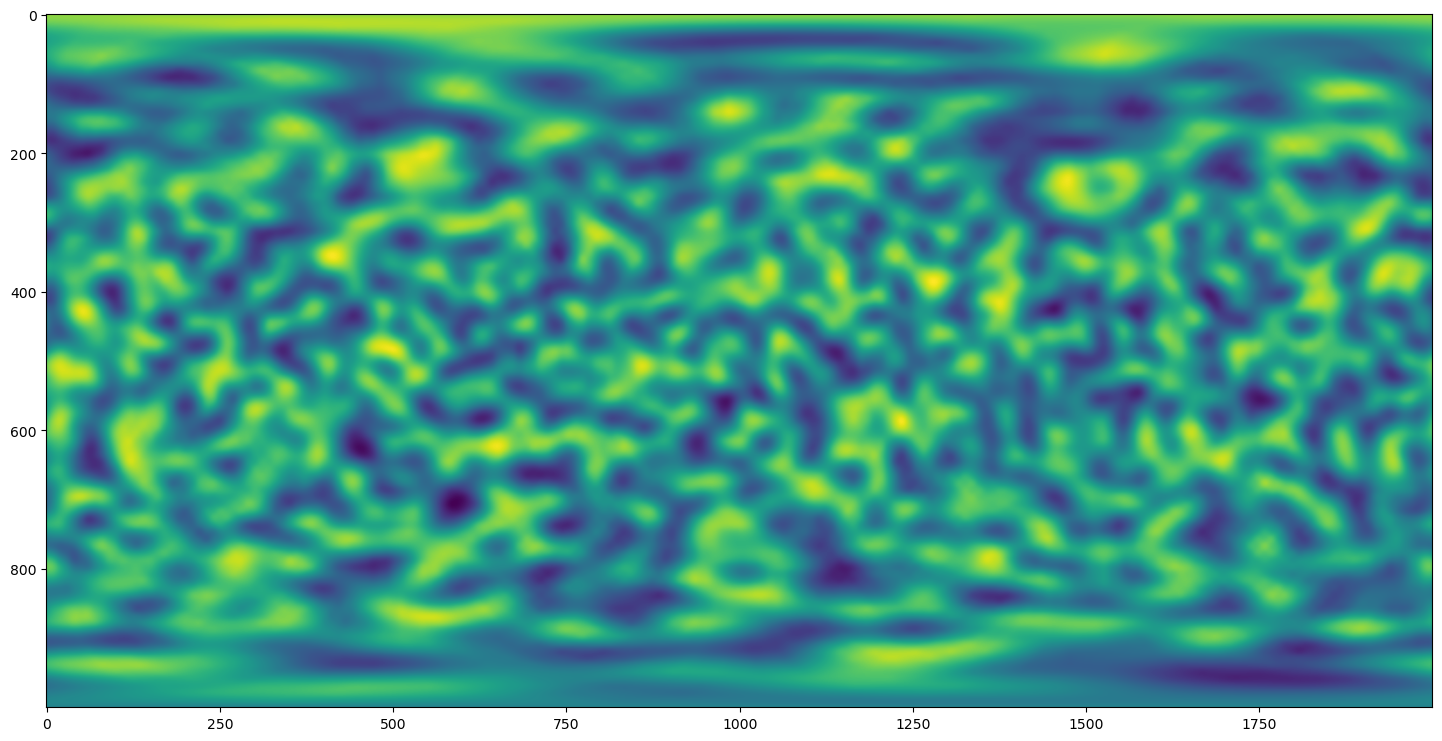

In [18]:
plt.figure(figsize=[18,9])
plt.imshow(ampliate(_noise_sph, 1000))

In [19]:
def fract_noise(x, y, level = 3):
    opensimplex.random_seed()
    base = opensimplex.noise2array(x, y)
    for i in range(level-1):
        j = i+2
        opensimplex.random_seed()
        base += opensimplex.noise2array(x*j, y*j)/j
    minz = np.min(base)
    maxz = np.max(base)
    dz = maxz-minz
    base = (base - minz)/dz
    return base

In [20]:
def fract_noise_sphere(N_hd, level = 3, minlevel = 2, N = 100):
    
    lat_vec = np.linspace(-np.pi/2, np.pi/2, N)
    long_vec = np.linspace(-np.pi/2, np.pi/2, 2*N)
    
    xy_ones = np.ones([N, 2*N])
    lat_arr = xy_ones * np.expand_dims(lat_vect, 1)
    long_arr = xy_ones * np.expand_dims(long_vect, 0)
    
    base = noise_sphere(long_arr, lat_arr, 2*N, scale = minlevel)
    for i in range(minlevel+1, level+1):
        base += noise_sphere(long_arr, lat_arr, 2*N, scale = i)
    minz = np.min(base)
    maxz = np.max(base)
    dz = maxz-minz
    base = (base - minz)/dz
    return ampliate(base, N_hd)

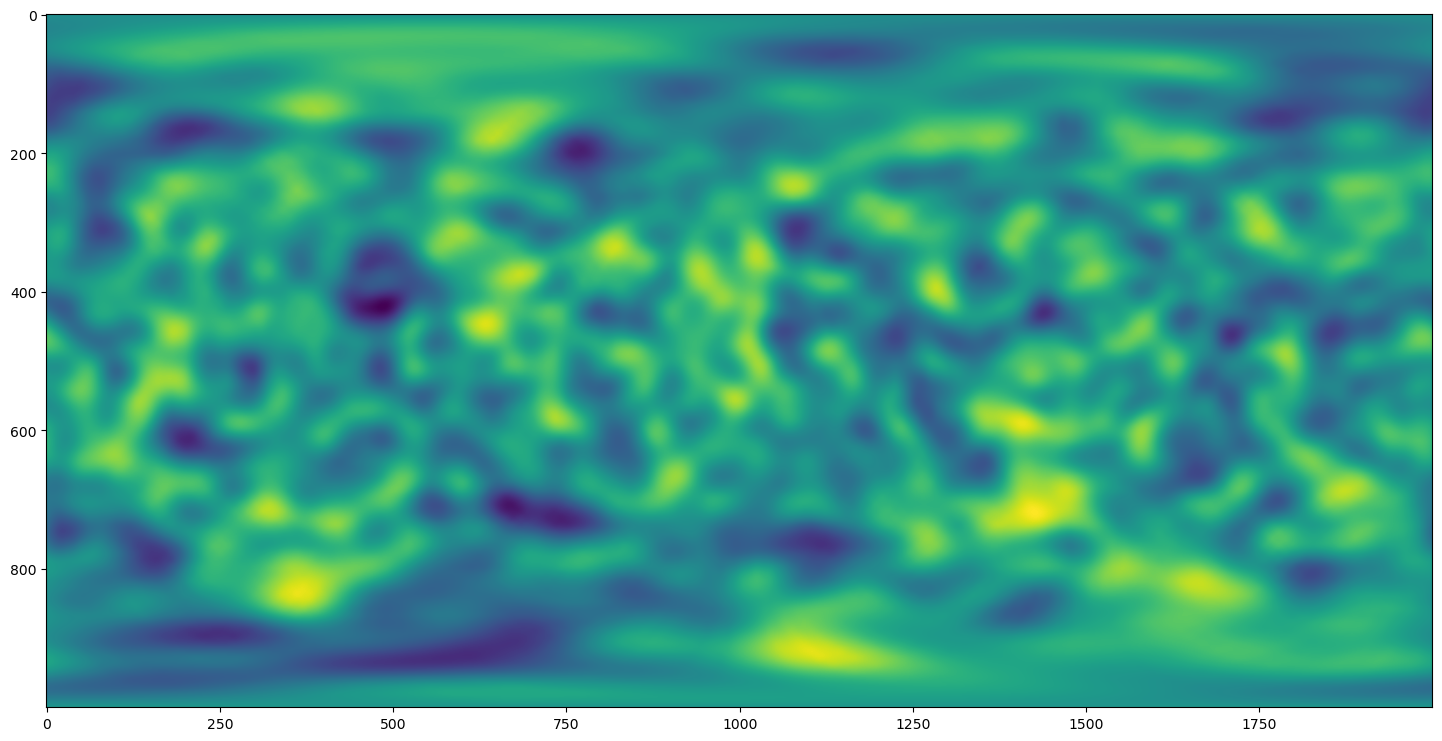

In [21]:
plt.figure(figsize=[18,9])
plt.imshow(fract_noise_sphere(1000,7))

In [22]:
def noisy_plates(N_plates = 10, N_hd = 1000, rand_k = 0.5, level = 3):

    centers = []
    for i in range(N_plates):
        centers.append(tuple((np.random.rand(2)*2-1)*np.array([np.pi, np.pi/2])))

    cent_dist = np.zeros([Nlat, Nlong, N_plates])
    for i in range(N_plates):
        cent_dist[:,:,i] = dist_map(*centers[i], long_arr, lat_arr) * (0.5 + rand_k *fract_noise_sphere(Nlat,level))
        
        
    cent_dist_hd = np.zeros([N_hd, N_hd*2, N_plates])
    for i in range(N_plates):
        cent_dist_hd[:,:,i] = ampliate(cent_dist[:,:,i], N_hd)
        
    plate_map = np.argmin(cent_dist_hd, axis=2)
    return plate_map, np.array(centers)

In [23]:
plates, centers = noisy_plates(rand_k=0.3, level = 5)

In [24]:
centers_mov = np.random.rand(10, 2)
centers_mov[:,0] = centers_mov[:,0]*2*np.pi
c_mov_uv = np.zeros_like(centers_mov)
c_mov_uv[:,0] = centers_mov[:,1] * np.cos(centers_mov[:,0])
c_mov_uv[:,1] = centers_mov[:,1] * np.sin(centers_mov[:,0])

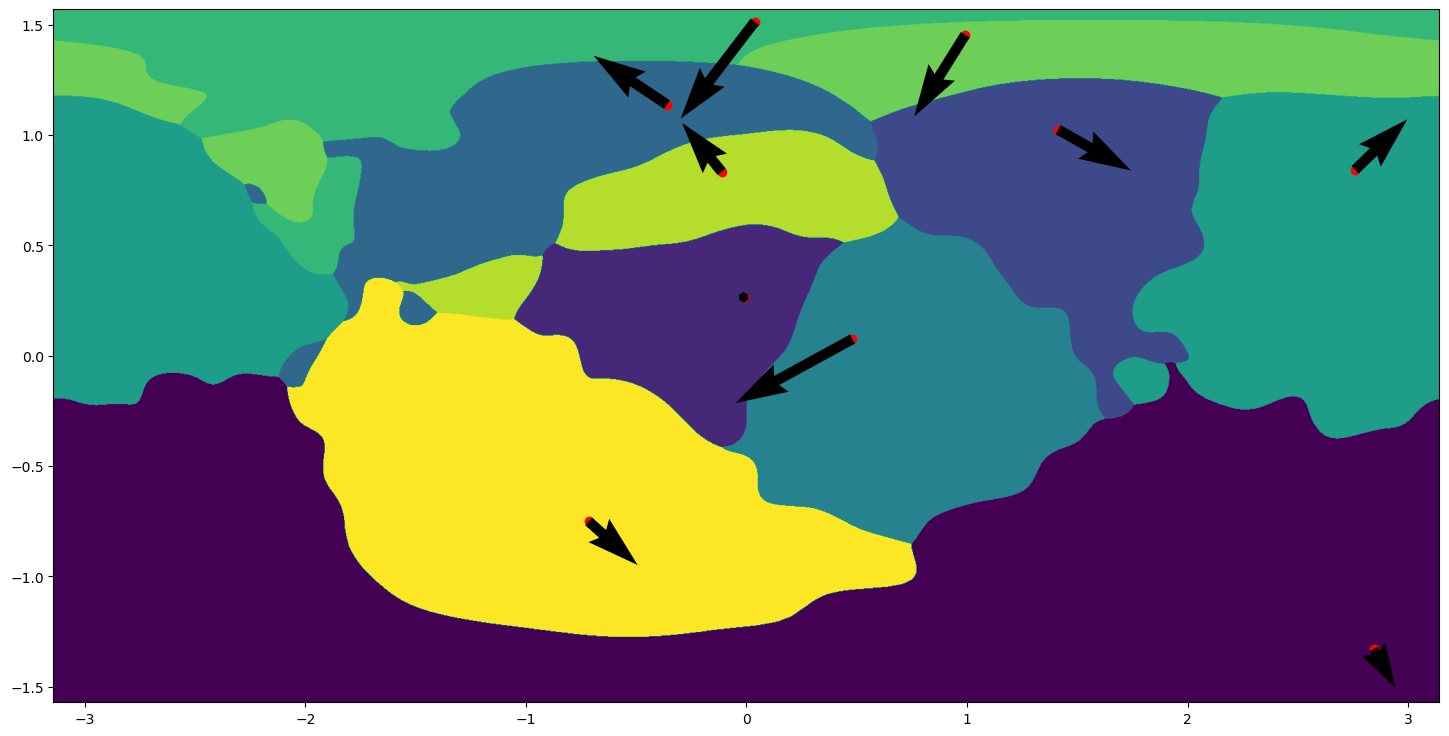

In [25]:
plt.figure(figsize=[18,9])
plt.imshow(plates, origin = 'lower', extent = (-np.pi, np.pi, -np.pi/2, np.pi/2))
plt.scatter(centers[:,0],centers[:,1], c = 'red')
plt.quiver(centers[:,0],centers[:,1],c_mov_uv[:,0],c_mov_uv[:,1])

In [26]:
c_mov_cart = np.zeros([10,3])
_u = c_mov_uv[:,0]
_v = c_mov_uv[:,1]
_lat = centers[:,1]
_long = centers[:,0]
c_mov_cart[:,0] = - _u * np.sin(_long) - _v * np.sin(_lat)*np.cos(_long)
c_mov_cart[:,1] =   _u * np.cos(_long) - _v * np.sin(_lat)*np.sin(_long)
c_mov_cart[:,2] =   _v * np.cos(_lat)

In [27]:
centers_cart = np.zeros([10,3])
centers_cart[:,0] = np.cos(_lat)*np.cos(_long)
centers_cart[:,1] = np.cos(_lat)*np.sin(_long)
centers_cart[:,2] = np.sin(_lat)

In [28]:
omegas = np.cross(c_mov_cart,centers_cart)

In [29]:
cart_arr = np.zeros([100,200,3])
cart_arr[:,:,0] = np.cos(lat_arr)*np.cos(long_arr)
cart_arr[:,:,1] = np.cos(lat_arr)*np.sin(long_arr)
cart_arr[:,:,2] = np.sin(lat_arr)

In [30]:
surf_speeds_map_cart = np.zeros([100 ,200, 10, 3 ])
for ii in range(10):
    surf_speeds_map_cart[:,:,ii,:] = np.cross(cart_arr, omegas[ii,:])

In [31]:
rot_matrix = np.zeros([100,200,3,3])
rot_matrix[:,:,0,0]= -np.sin(long_arr)
rot_matrix[:,:,0,1]= -np.sin(lat_arr) * np.cos(long_arr)
rot_matrix[:,:,0,2]= np.cos(lat_arr) * np.cos(long_arr)
rot_matrix[:,:,1,0]= np.cos(long_arr)
rot_matrix[:,:,1,1]= -np.sin(lat_arr) * np.sin(long_arr)
rot_matrix[:,:,1,2]= np.cos(lat_arr) * np.sin(long_arr)
rot_matrix[:,:,2,0]= 0
rot_matrix[:,:,2,1]= np.cos(lat_arr)
rot_matrix[:,:,2,2]= np.sin(lat_arr)

In [32]:
surf_speeds_map = np.matmul(surf_speeds_map_cart, rot_matrix)

In [33]:
speedmap = np.zeros([100,200,2])
reduced_plate = plates[::10,::10]
for i in range(100):
    for j in range(200):
        ind_map = reduced_plate[i,j]
        speedmap[i,j,:] = surf_speeds_map[i,j,ind_map,:2]

In [89]:
speedmap_hd = np.zeros([N_hd, 2*N_hd, 2])
speedmap_hd[:,:,0] = ampliate(speedmap[:,:,0], N_hd)
speedmap_hd[:,:,1] = ampliate(speedmap[:,:,1], N_hd)

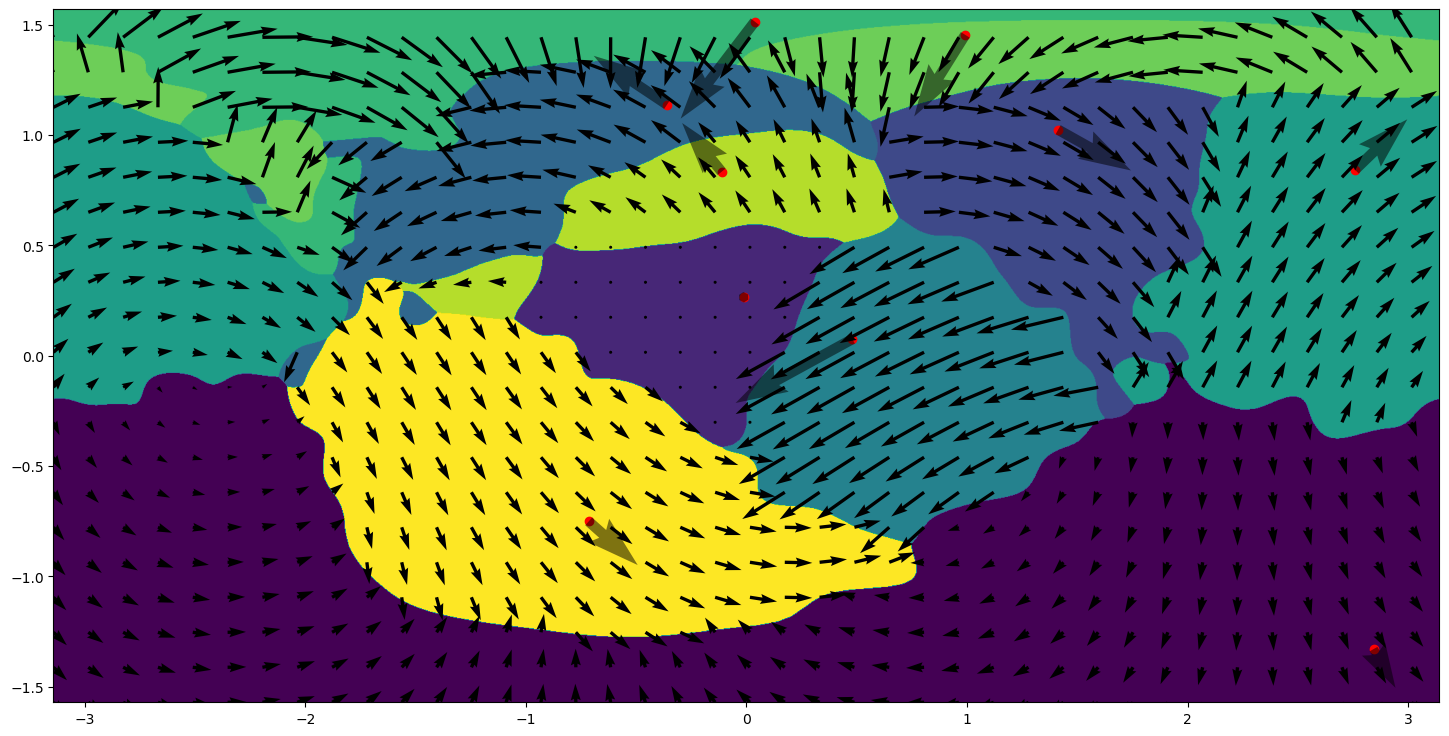

In [34]:
plt.figure(figsize=[18,9])
plt.imshow(plates, origin = 'lower', extent = (-np.pi, np.pi, -np.pi/2, np.pi/2))
plt.scatter(centers[:,0],centers[:,1], c = 'red')
plt.quiver(centers[:,0],centers[:,1],c_mov_uv[:,0],c_mov_uv[:,1], alpha = 0.5)
plt.quiver(long_arr[::5,::5] ,lat_arr[::5,::5],speedmap[::5,::5,0],speedmap[::5,::5,1])

In [53]:
_borders = np.zeros([N_hd, 2*N_hd, 9], dtype = int)
for ii in range(3):
    for jj in range(3):
        layer = jj+3*ii
        x_d = ii-1
        y_d = jj-1
        _dp = np.roll(plates, (x_d, y_d), (0,1))
        _borders[:,:,layer] = np.abs(plates-_dp)
_borders_flat = np.sum(_borders, axis=2)
borders = np.where(_borders_flat>0, 1, 0)
borders[[-1,0], :] = 0

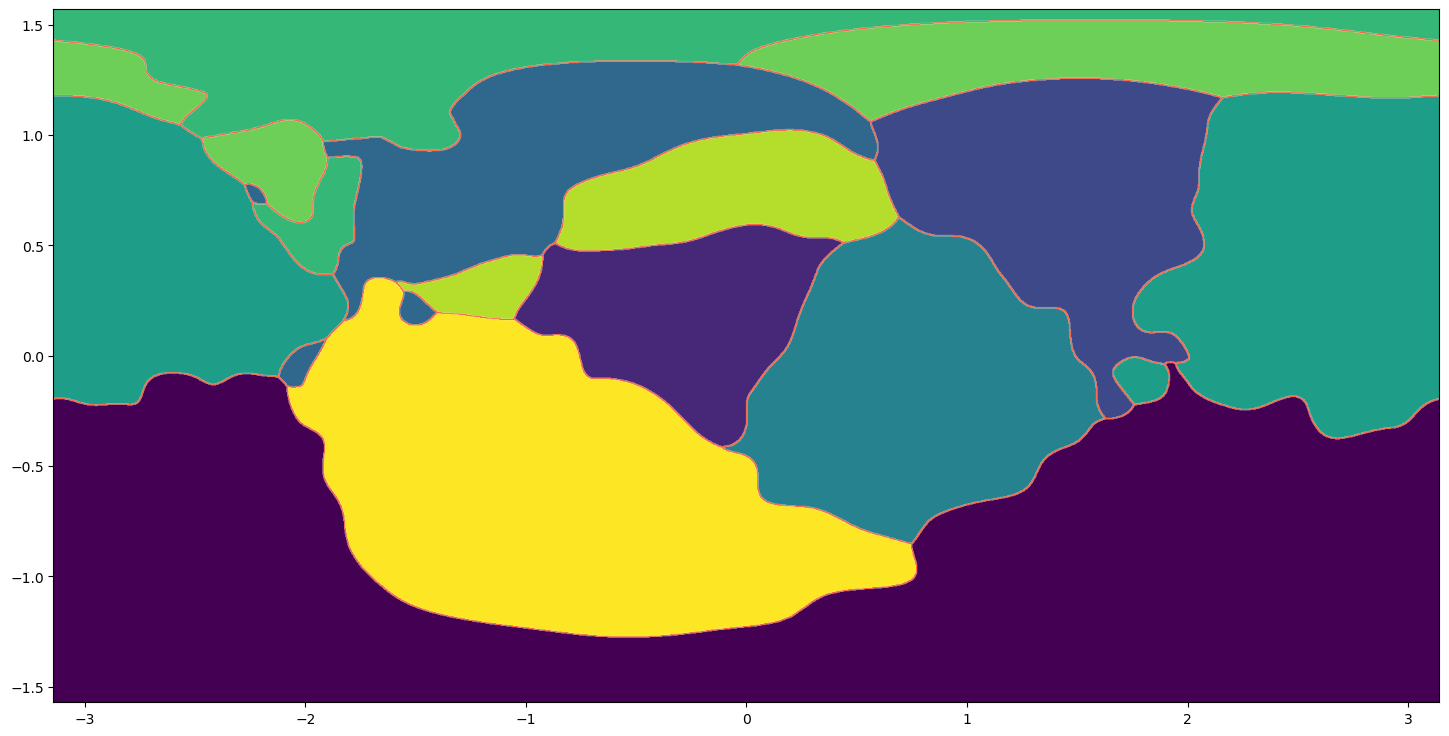

In [64]:
plt.figure(figsize=[18,9])
plt.imshow(plates, origin = 'lower', extent = (-np.pi, np.pi, -np.pi/2, np.pi/2))
plt.imshow(borders, cmap= 'Reds', vmin= 0, vmax= 2, alpha = borders.astype(float), origin = 'lower', extent = (-np.pi, np.pi, -np.pi/2, np.pi/2))

In [79]:
class borderpoint:
    def __init__(self, lat, long):
        self.lat = lat
        self.long = long
        self.coord = (lat,long)
        self.bordertype = None
        self.plate = None
        self.otherplate = None
    def __str__(self):
        return f"Point {self.coord} plate {self.plate} type {self.bordertype} contact w {self.otherplate}"

In [80]:
border_dict = {}
lat_vect_hd = np.linspace(-np.pi/2, np.pi/2, N_hd)
long_vect_hd = np.linspace(-np.pi, np.pi, 2 * N_hd)
for i in range(N_hd):
    for j in range(2*N_hd):
        if borders[i,j] == 1:
            border_dict[(i,j)] = borderpoint(lat_vect_hd[i], long_vect_hd[j])

In [83]:
def searchothers(i,j):
    _curr = plates[i,j]
    others = []
    for _a in range(3):
        a = _a-1
        for _b in range(3):
            b = _b-1
            _look = plates[i+a,j+b]
            if _look != _curr and _look not in others:
                others.append(_look)
    return others

In [87]:
for key in border_dict:
    _plt = plates[key]
    border_dict[key].plate = _plt
    _others = searchothers(*key)
    if len(_others) == 1:
        _others = _others[0]
    else:
        border_dict[key].bordertype = 'triple'
    border_dict[key].otherplate = _others
    print(key, border_dict[key])

(93, 800) Point (-1.2783357494336847, -0.6270612650236758) plate 0 type None contact w 9
(93, 801) Point (-1.2783357494336847, -0.6239181007879679) plate 0 type None contact w 9
(93, 802) Point (-1.2783357494336847, -0.6207749365522601) plate 0 type None contact w 9
(93, 803) Point (-1.2783357494336847, -0.6176317723165528) plate 0 type None contact w 9
(93, 804) Point (-1.2783357494336847, -0.6144886080808449) plate 0 type None contact w 9
(93, 805) Point (-1.2783357494336847, -0.6113454438451376) plate 0 type None contact w 9
(93, 806) Point (-1.2783357494336847, -0.6082022796094297) plate 0 type None contact w 9
(93, 807) Point (-1.2783357494336847, -0.6050591153737219) plate 0 type None contact w 9
(93, 808) Point (-1.2783357494336847, -0.6019159511380145) plate 0 type None contact w 9
(93, 809) Point (-1.2783357494336847, -0.5987727869023067) plate 0 type None contact w 9
(93, 810) Point (-1.2783357494336847, -0.5956296226665989) plate 0 type None contact w 9
(93, 811) Point (-1.2

IndexError: index 2000 is out of bounds for axis 1 with size 2000

In [91]:
from contourpy import contour_generator

In [94]:
cont_gen = contour_generator(z = _noise_sph)

In [143]:
_noise_sph = fract_noise_sphere(100,4, minlevel=1)
cont_gen = contour_generator(z = _noise_sph)

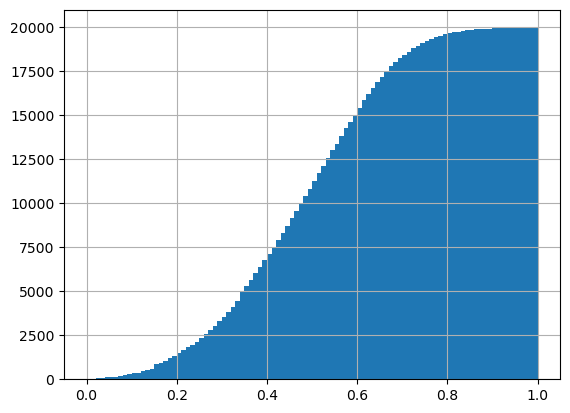

In [152]:
_hist_y, _hist_x,_ = plt.hist(_noise_sph.flatten(), 100, cumulative=True, )
plt.grid()

In [153]:
_hist_y

array([1.5000e+01, 3.5000e+01, 5.6000e+01, 8.0000e+01, 1.0700e+02,
       1.3200e+02, 1.5700e+02, 1.9800e+02, 2.5000e+02, 2.9700e+02,
       3.3800e+02, 3.8200e+02, 4.4800e+02, 5.0400e+02, 5.6800e+02,
       8.4300e+02, 9.3800e+02, 1.0400e+03, 1.2090e+03, 1.3420e+03,
       1.4650e+03, 1.6810e+03, 1.8130e+03, 1.9540e+03, 2.1220e+03,
       2.3270e+03, 2.5970e+03, 2.8230e+03, 3.0410e+03, 3.2930e+03,
       3.5580e+03, 3.8240e+03, 4.1310e+03, 4.4580e+03, 4.9700e+03,
       5.3110e+03, 5.6580e+03, 6.0200e+03, 6.3750e+03, 6.7720e+03,
       7.1360e+03, 7.5060e+03, 7.9070e+03, 8.3190e+03, 8.7320e+03,
       9.1660e+03, 9.5640e+03, 9.9830e+03, 1.0395e+04, 1.0800e+04,
       1.1255e+04, 1.1699e+04, 1.2121e+04, 1.2593e+04, 1.3001e+04,
       1.3388e+04, 1.3816e+04, 1.4250e+04, 1.4646e+04, 1.5035e+04,
       1.5440e+04, 1.5869e+04, 1.6216e+04, 1.6568e+04, 1.6872e+04,
       1.7195e+04, 1.7493e+04, 1.7783e+04, 1.8008e+04, 1.8247e+04,
       1.8415e+04, 1.8616e+04, 1.8823e+04, 1.8963e+04, 1.9107e

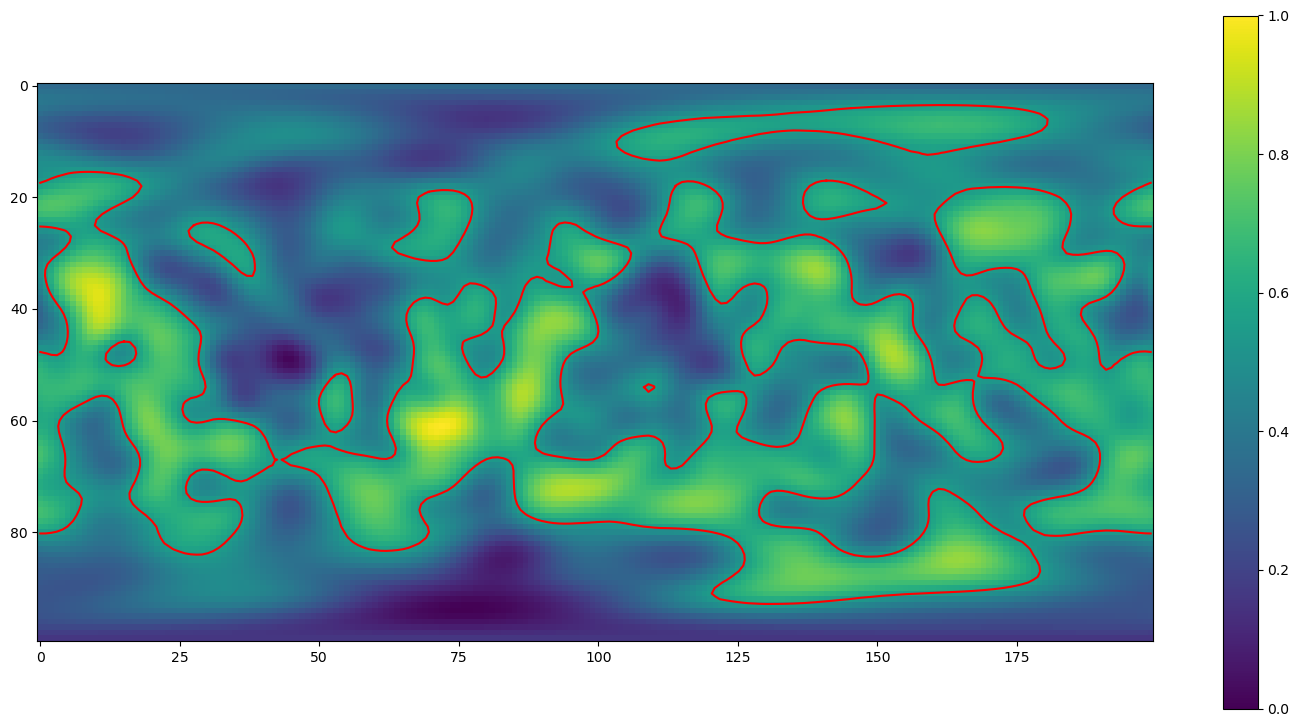

In [144]:
lines = cont_gen.lines(0.55)
plt.figure(figsize=[18,9])
plt.imshow(_noise_sph)
plt.colorbar()
for line in lines:
    plt.plot(line[:,0],line[:,1], c = 'red')